In [1]:
%load_ext autoreload
%autoreload 2

from pangolin.interface import *
#from matplotlib import pyplot as plt
from pangolin.interface import *
from pangolin.loops import VMapRV
from pangolin import new_infer as infer

()

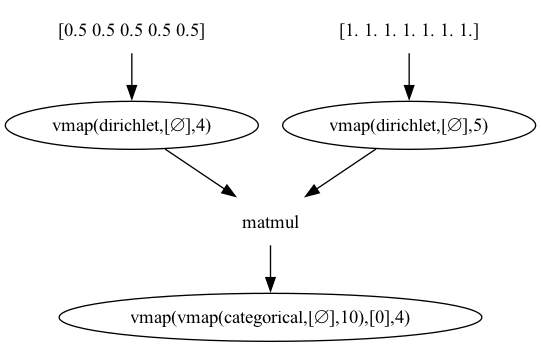

skipping MCMC...
shape   | statement
------- | ---------
(5,)    | a = [0.5 0.5 0.5 0.5 0.5]
(4, 5)  | b ~ vmap(dirichlet,[∅],4)(a)
(7,)    | c = [1. 1. 1. 1. 1. 1. 1.]
(5, 7)  | d ~ vmap(dirichlet,[∅],5)(c)
(4, 7)  | e = matmul(b,d)
(4, 10) | f ~ vmap(vmap(categorical,[∅],10),[0],4)(e)


In [2]:
# topics integrated out, word outputs

N = 10 # number of words in each document
M = 4 # number of documents
K = 5 # number of topics
V = 7 # number of words

α = makerv(0.5*np.ones(K))
β = makerv(np.ones(V))
θ = plate(N=M)(lambda: dirichlet(α))
φ = plate(N=K)(lambda: dirichlet(β))
p = θ @ φ # M x V matrix: p[m,v] is prob of getting word v in document m
w = plate(p)(lambda p_m:
             plate(N=N)(lambda:
                        categorical(p_m)))
display(viz_upstream(w))
ws = infer.sample(w,niter=1)
assert ws[0].shape == (M, N)

print_upstream(w)

In [3]:
print_upstream(vmap(vmap(bernoulli,None,10),None,3)(0.5))

shape   | statement
------- | ---------
()      | a = 0.5
(3, 10) | b ~ vmap(vmap(bernoulli,[∅],10),[∅],3)(a)


shape      | statement
---------- | ---------
(7,)       | a = [1. 1. 1. 1. 1. 1. 1.]
(5, 7)     | b ~ vmap(dirichlet,[∅],5)(a)
(5,)       | c = [0.5 0.5 0.5 0.5 0.5]
(4, 5)     | d ~ vmap(dirichlet,[∅],4)(c)
(4, 10)    | e ~ vmap(vmap(categorical,[∅],10),[0],4)(d)
(4, 10, 7) | f = vmap(vmap(index(∅,:),[∅, 0],10),[∅, 0],4)(b,e)
(4, 10)    | g ~ vmap(vmap(categorical,[0],10),[0],4)(f)


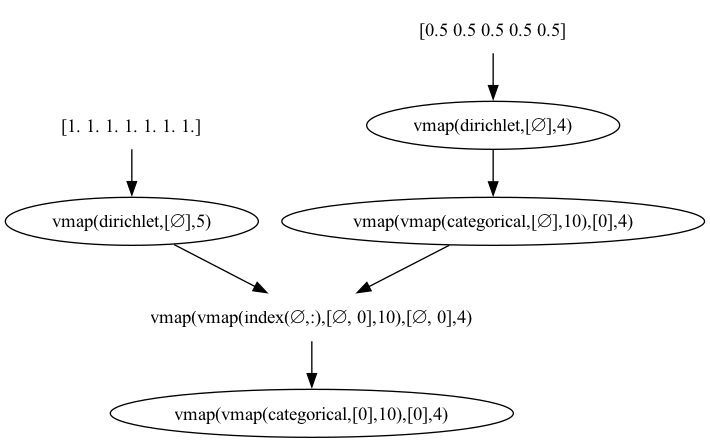

In [8]:
# MAXIMALLY NAIVE MODEL, WRITTEN USING FAKELOOPS

N = 10 # number of words in each document
M = 4 # number of documents
K = 5 # number of topics
V = 7 # number of words

α = makerv(0.5*np.ones(K))
β = makerv(np.ones(V))
θ = VMapRV()
φ = VMapRV()
w = VMapRV()
z = VMapRV()
with Loop(M) as m:
    θ[m] = dirichlet(α) # M x K
with Loop(K) as k:
    φ[k] = dirichlet(β) # K x V
with Loop(M) as m:
    with Loop(N) as n:
        z[m,n] = categorical(θ[m,:]) # M x K
        w[m,n] = categorical(φ[z[m,n],:])

print_upstream(w)
viz_upstream(w)

In [3]:
# OPTIMIZED MODEL, WRITTEN USING FAKELOOPS

N = 10 # number of words in each document
M = 4 # number of documents
K = 5 # number of topics
V = 7 # number of words

α = makerv(0.5*np.ones(K))
β = makerv(np.ones(V))
θ = VMapRV()
φ = VMapRV()
c = VMapRV()
with Loop(M) as m:
    θ[m] = dirichlet(α) # M x K
with Loop(K) as k:
    φ[k] = dirichlet(β) # K x V
p = θ @ φ # M x V
with Loop(M) as m:
    c[m] = multinomial(N, p[m,:]) # M x V

print_upstream(c)

shape  | statement
------ | ---------
()     | a = 10
(5,)   | b = [0.5 0.5 0.5 0.5 0.5]
(4, 5) | c ~ vmap(dirichlet,[∅],4)(b)
(7,)   | d = [1. 1. 1. 1. 1. 1. 1.]
(5, 7) | e ~ vmap(dirichlet,[∅],5)(d)
(4, 7) | f = matmul(c,e)
(4, 7) | g ~ vmap(multinomial,[∅, 0],4)(a,f)


In [10]:
# playing around with loop notation

x = VMapRV()
with Loop(M) as m:
    x[m] = normal(0,1)
print_upstream(x)

with Loop(M) as m:
    (x:=VMapRV())[m] = normal(0,1)
print_upstream(x)

def VV():
    while True:
        yield VMapRV()

vv = VV()
with Loop(M) as m:
    (x:=next(vv))[m] = normal(0,1)
print_upstream(x)

class VMapRVMaker:
    @property
    def v(self):
        return VMapRV()

vv = VMapRVMaker()
with Loop(M) as m:
    (x:=vv.v)[m] = normal(0,1)
print_upstream(x)

shape | statement
----- | ---------
()    | a = 0
()    | b = 1
(4,)  | c ~ vmap(normal_scale,[∅, ∅],4)(a,b)
shape | statement
----- | ---------
()    | a = 0
()    | b = 1
(4,)  | c ~ vmap(normal_scale,[∅, ∅],4)(a,b)
shape | statement
----- | ---------
()    | a = 0
()    | b = 1
(4,)  | c ~ vmap(normal_scale,[∅, ∅],4)(a,b)
shape | statement
----- | ---------
()    | a = 0
()    | b = 1
(4,)  | c ~ vmap(normal_scale,[∅, ∅],4)(a,b)


In [ ]:
viz_samples_live(w)

In [ ]:
# topics integrated out, word count outputs

N = 10 # number of words in each document
M = 4 # number of documents
K = 5 # number of topics
V = 7 # number of words

α = makerv(np.ones(K))
β = makerv(np.ones(V))
θ = plate(N=M)(lambda: dirichlet(α))
φ = plate(N=K)(lambda: dirichlet(β))
p = θ @ φ # M x V matrix: p[m,v] is prob of getting word v in document m
c = plate(p)(lambda p_m:
            multinomial(N, p_m))
display(viz_upstream(w))
cs = infer.sample(c,niter=1)
assert cs[0].shape == (M, V)

In [ ]:
# explicitly construct topics

N = 10 # number of words in each document
M = 4 # number of documents
K = 5 # number of topics
V = 7 # number of words

α = makerv(0.5*np.ones(K))
β = makerv(1*np.ones(V))
θ = plate(N=M)(lambda: dirichlet(α))
φ = plate(N=K)(lambda: dirichlet(β))
z = plate(θ)(lambda θ_m:
             plate(N=N)(lambda:
                        categorical(θ_m)))
assert z.shape == (M,N) # each entry of z is between 0 and K
φz = φ[z]
assert φz.shape == (M,N,V)

w = plate(φz)(lambda φz_m:
              plate(φz_m)(lambda φz_mn:
                          categorical(φz_mn)))

assert w.shape == (M,N)

αs, θs, zs, ws = infer.sample((α,θ,z,w),niter=1)

viz_upstream(w,[],{θ:'θ',φ:'φ',z:'z',w:'w'})

In [ ]:
# explicitly construct topics and words in same plate structure

N = 10 # number of words in each document
M = 4 # number of documents
K = 5 # number of topics
V = 7 # number of words

α = makerv(0.5*np.ones(K))
β = makerv(1*np.ones(V))
θ = plate(N=M)(lambda: dirichlet(α))
φ = plate(N=K)(lambda: dirichlet(β))
z, w = plate(θ)(lambda θ_m:
             plate(N=N)(lambda:
                        (z_mn := categorical(θ_m),
                         w_mn := categorical(φ[z_mn]))))

assert z.shape == (M,N)
assert w.shape == (M,N)

αs, θs, zs, ws = infer.sample((α,θ,z,w),niter=1)

viz_upstream(w,[],{θ:'θ',φ:'φ',z:'z',w:'w'})

is there a simpler version of this "matrix multiply to integrate out categorical" operation?

Sure. Of course.

* All that's *really* happening here seems to be: In general you can integrate out discrete latent variables to get a mixture. But *here* that mixture happens to have a closed form because a mixture of categorical distributions is still a categorical distribution.

In [ ]:
locs = makerv(np.random.randn(3))
scales = makerv(np.abs(np.random.randn(3)))
a = vmap(normal,0)(locs,scales)
i = categorical([.2,.7,.1])
x = a[i]
xs = infer.sample(x,niter=1000000)
np.mean(xs)
viz_upstream(x)

In [ ]:
a = vmap(normal,0)(locs,scales)
Ex = makerv([.2,.7,.1]) @ a
Exs = infer.sample(Ex,niter=1000000)
np.mean(Exs)
viz_upstream(Ex)